In [1]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp_sst5v/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp_sst5v/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)


In [2]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [3]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((100,64*64))
trX=trX/255
trX[trX>=0.5]=1
trX[trX<=0.5]=0
%matplotlib inline
for i in range(100):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    temp[temp>=0.5]=1
    temp[temp<=0.5]=0
    data2[i,:]=temp.reshape(-1)

In [4]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

def batchnorm( x, g=None, b=None, eps=1e-8 ):
    if x.ndim == 4:
        m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
        v = tensor.mean(tensor.sqr(x - m), 
                          axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

    elif x.ndim == 2:
        m = tensor.mean(x, axis=0)
        v = tensor.mean(tensor.sqr(x - m), axis=0)

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g + b

    return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

def leaky_rectify( x, leak=0.2 ):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x)   

In [16]:
import sys
sys.path.append('..')

import os
import json
import scipy.io
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import math
import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import conv_cond_concat, deconv, dropout
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score
np.set_printoptions(threshold='nan')
#from load import mnist_with_valid_set

#trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()

#image = scipy.io.loadmat('WB_test64_GAN.mat')
#data1=np.abs(image['WB_test64_GAN']-1)

vaX= data2[0:100]
trX= data2[0:100]
#vaX= data2
#trX= data2
vaX = floatX(vaX)

k = 1             # # of discrim updates for each gen update
l2 = 1.5e-4       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
#ny = 10           # # of classes
nbatch = 10      # # of examples in batch
npx = 64          # # of pixels width/height of images
nz = 2          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 40          # # of gen filters in first conv layer
ndf = 40          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 10000       # # of iter at starting learning rate
niter_decay = 1 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
#ntrain, nval, ntest = len(trX), len(vaX), len(teX)
ntrain = len(trX)

def transform(X):
    return (floatX(X)).reshape(-1, nc, npx, npx)
    #return (floatX(X)).reshape(-1, nc, npx, npx)
def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X

relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()

bce = T.nnet.binary_crossentropy
tanh = activations.Tanh()

eifn = inits.Normal(scale=0.02)
gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)

#encoder
ew  = difn((ndf, nc, 5, 5), 'ew')
eg1 = gain_ifn((ndf), 'eg1')
eb1 = bias_ifn((ndf), 'eb1')
ew2 = difn((ndf*2, ndf, 5, 5), 'ew2')
eg2 = gain_ifn((ndf*2), 'eg2')
eb2 = bias_ifn((ndf*2), 'eb2')
ew3 = difn((ndf*4, ndf*2,5,5), 'ew3')
eg3 = gain_ifn((ndf*4), 'eg3')
eb3 = bias_ifn((ndf*4), 'eb3')
ew4 = difn((ndf*4*8*8, 1000), 'ew4')
eb4 = bias_ifn((1000), 'eb4')
bwe4= eifn((1000),'bwe4')
bbe4= bias_ifn((1000),'bbe4')
wmu = difn((1000, nz), 'wmu')
bmu = bias_ifn((nz), 'bmu')
wsigma = difn((1000, nz), 'wsigma')
bsigma = bias_ifn((nz), 'bsigma')


#decoder
wd4 = gifn((nz, ndf*4*8*8), 'wd4')
bd4 = bias_ifn((ndf*4*8*8),'bd4')
bwd4 = gifn((ndf*4*8*8), 'bwd4')
bbd4 = bias_ifn((ndf*4*8*8), 'bbd4')
wd3 = gifn((ngf*4, ngf*4, 5, 5), 'wd3')
bwd3 = gain_ifn((ngf*4), 'bwd3')
bbd3 = bias_ifn((ngf*4), 'bbd3')
wd2 = gifn((ngf*2, ngf*4, 5, 5), 'wd2')
bwd2 = gain_ifn((ngf*2), 'bwd2')
bbd2 = bias_ifn((ngf*2), 'bbd2')
wd1 = gifn((ngf, ngf*2, 5, 5),'wd1')
bwd1 = gain_ifn((ngf),'bwd1')
bbd1 = bias_ifn((ngf),'bbd1')
wd0 = gifn((nc,ngf,5,5), 'wd0')
bwd = bias_ifn((nc),'bwd')

#discriminator
wg1 = difn((ndf, nc, 5, 5), 'wg1')
wg2 = difn((ndf*2, ndf, 5, 5), 'wg2')
wg3 = difn((ndf*4, ndf*2, 5, 5), 'wg3')
wg4 = difn((ndf*4, ndf*4, 5, 5), 'wg4')
wg5 = difn((ndf*4*8*8,1000), 'wg5')
bg5 = bias_ifn((1000),'bg5')
wg6 = difn((1000,1), 'wg6')
bg6 = bias_ifn((1),'bg6')



X = T.tensor4()
Z = T.matrix()

enc_params= [ew, eb1, ew2, eb2, ew3, eb3, ew4, eb4, wmu, bmu, wsigma, bsigma]
gen_params= [wd4, bd4, wd3, bbd3, wd2, bbd2, wd1, bbd1, wd0, bwd]
dis_params= [wg1, wg2, wg3, wg4, wg5, bg5, wg6, bg6]


def enc(X, w, b1, we2, b2, we3, b3, g4, b4, wmu, bmu, wsigma, bsigma):
    h1 = leaky_rectify(( max_pool( conv( X,  w, b1), (2,2) )) )
    h2 = leaky_rectify(( max_pool( conv( h1, we2, b2), (2,2) )) )
    h3  = leaky_rectify(( max_pool( conv( h2, we3, b3), (2,2) )) )
    h3_ = h3.reshape((-1,8*8*160))
    h4 = leaky_rectify(( full_conn( h3_, g4, b4 )))   
    z_mu = theano.dot( h4, wmu ) + bmu
    z_log_simga = 0.5 * (theano.dot(h4, wsigma) + bsigma)
    return z_mu, z_log_simga

def gen(sampling_Z, wd4, bd4, wd3, bbd3, wd2, bbd2, wd1, bbd1, wd0, bwd):
    
    h5  = rectify(( full_conn( sampling_Z,  wd4, bd4 )) )
    h5_ = h5.reshape( (-1,160, 8, 8) )
    h6  = rectify(( conv( depool( h5_, factor=2 ), wd3, bbd3 )) )
    h7  = rectify(( conv( depool( h6 , factor=2 ), wd2, bbd2)) )
    h8  = rectify(( conv( depool( h7,  factor=2 ), wd1, bbd1 )) )
    x_tilde   = sigmoid( conv( h8, wd0, bwd ) )
    return x_tilde


def dis(X_tilde, wg1, wg2, wg3, wg4, wg5, bg5, wg6, bg6):
    h1 = leaky_rectify( conv( X_tilde,  wg1 ) )
    h2 = leaky_rectify( max_pool( conv( h1, wg2 ), (2,2) ) )
    h3 = leaky_rectify( max_pool( conv( h2, wg3 ), (2,2) ) )
    h4 = leaky_rectify( max_pool( conv( h3, wg4 ), (2,2) ) )
    h4_ = h4.reshape( (-1,160*(8**2)) )
    h5 = leaky_rectify( full_conn( h4_, wg5, bg5 ) )
    h6 = sigmoid(full_conn( h5, wg6, bg6 ))
    image_feature = h3

    return h6, image_feature

encZ_mu, encZ_log_sigma = enc(X, *enc_params)

from keras import backend as K
epsilon = K.random_normal(shape=(nbatch, nz), mean=0.,
                              std=0.01)
sampling_Z = encZ_mu + T.exp(encZ_log_sigma / 2) * epsilon

X_tilde = gen(sampling_Z, *gen_params)
Z_rand = K.random_normal(shape=(nbatch, nz), mean=0.,std=0.01)
X_p = gen(Z_rand, *gen_params)

d_real, xl_real = dis(X, *dis_params)
d_gen, xl_gen = dis(X_tilde, *dis_params)
d_p, xl_p = dis(X_p, *dis_params)

enc_loss_kl = -0.5*T.mean(1+encZ_log_sigma-T.square(encZ_mu)-T.exp(encZ_log_sigma),axis=-1)
enc_loss_sim= T.mean(T.sum((xl_gen-xl_real)**2))

# d_cost_real = bce(d_real, T.ones(d_real.shape)).mean()
# d_cost_gen = bce(d_gen, T.zeros(d_gen.shape)).mean()
# d_cost_p = bce(d_p, T.zeros(d_p.shape)).mean()

d_cost_real = bce(d_real, T.zeros(d_real.shape)).mean()
d_cost_gen = bce(d_gen, T.ones(d_gen.shape)).mean()
d_cost_p = bce(d_p, T.ones(d_p.shape)).mean()

GAN_loss = (d_cost_real + d_cost_gen + d_cost_p)
#GAN_loss = (T.log(d_real)+T.log(1-d_cost_gen)+T.log(1-d_cost_p)).mean()

enc_cost = T.mean(enc_loss_kl + enc_loss_sim)
#gen_cost = enc_loss_sim + GAN_loss
#gen_cost = d_cost_gen + d_cost_p + enc_loss_sim
#gen_cost = d_cost_p + enc_loss_sim
#gen_cost = 0.1*enc_loss_sim + (-1*T.log(d_p)).mean() # timsainb tensorflow version
gen_cost = 0.1*enc_loss_sim - GAN_loss # paper version
#dis_cost = -GAN_loss
#dis_cost = bce(d_gen, T.ones(d_gen.shape)).mean() + bce(d_p, T.ones(d_p.shape)).mean() + bce(d_real, T.zeros(d_real.shape)).mean()
#dis_cost = bce(d_real, T.zeros(d_real.shape)).mean() + bce(d_p, T.ones(d_p.shape)).mean()
# dis_cost = (-1*(T.log(d_real)+T.log(1-d_p))).mean() # timsainb tensorflow version
dis_cost = GAN_loss # paper version


cost = [enc_cost,gen_cost,dis_cost]

lrt = sharedX(lr)
enc_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
gen_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
dis_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))

enc_updates = enc_updater(enc_params, enc_cost)
gen_updates = gen_updater(gen_params, gen_cost)
dis_updates = dis_updater(dis_params, dis_cost)

#updates = enc_updates + gen_updates + dis_updates

print 'COMPILING'
t = time()

_train_enc = theano.function([X], enc_cost, updates=enc_updates)
_train_gen = theano.function([X,Z_rand,sampling_Z], gen_cost, updates=gen_updates)
_train_dis = theano.function([X,Z_rand,sampling_Z], dis_cost, updates=dis_updates)
_enc = theano.function([X], [encZ_mu, encZ_log_sigma])
_gen = theano.function([sampling_Z], X_tilde)

print '%.2f seconds to compile theano functions'%(time()-t)

n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0
enc_cost_error=[]
gen_cost_error=[]
dis_cost_error=[]
t = time()
iter_error=0
print 'start training......'
for epoch in range(1, 2000):
    #trX = shuffle(trX)
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        
        e_cost = _train_enc(imb)
        
        encZ_mu, encZ_log_sigma = _enc(imb)
        epsilon = np.random.normal(0, 0.01, (nbatch, nz))        
        sampling_Z = encZ_mu + np.exp(encZ_log_sigma / 2) * epsilon
        sampling_Z = sampling_Z.astype(np.float32)
        g_cost = _train_gen(imb,zmb,sampling_Z)        
        d_cost = _train_dis(imb,zmb,sampling_Z)
        
        n_examples += len(imb)

        iter_error += 1
        enc_cost_error.append(e_cost)
        gen_cost_error.append(g_cost)
        dis_cost_error.append(d_cost)
        if (epoch) % 10 == 0:
            print '%.0f %.4f %.4f %.4f'%(epoch, e_cost, g_cost, d_cost)  
                


c:\anaconda\lib\site-packages\ipykernel\__main__.py:58: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


COMPILING


DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpckcsuu/4c3c5ae3759d16fdc0556b69bcd63537.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpckcsuu/4c3c5ae3759d16fdc0556b69bcd63537.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpji4l5r/349a3b7a259c1e9441b924d4fe577d5a.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpji4l5r/349a3b7a259c1e9441b924d4fe577d5a.exp



112.83 seconds to compile theano functions
start training......
10 1056.0520 103.0548 0.0031
10 977.4051 96.0219 0.0069
10 915.8253 89.0768 0.0113
10 977.5455 96.8913 0.0164
10 1148.2877 109.5234 0.0172
10 1057.7537 105.6874 0.0182
10 986.8414 96.4986 0.0044
10 1108.5442 109.7108 0.0018
10 793.5964 78.6761 0.0348
10 883.1289 87.6376 0.0129
20 517.5094 50.3830 0.2172
20 489.8630 48.6255 0.1264
20 448.3207 44.1529 0.0471
20 411.3638 40.0964 0.4158
20 571.6416 55.1808 0.9723
20 492.3301 48.1735 0.7503
20 392.9724 36.9751 0.2576
20 428.1888 41.8462 0.1603
20 352.5364 34.8200 0.2849
20 363.3838 35.6216 0.2283
30 374.6811 37.1626 0.0490
30 391.8409 38.5354 0.0888
30 385.3776 37.6074 0.0723
30 356.7236 34.9526 0.0132
30 426.2620 42.1378 0.0114
30 411.7375 40.3138 0.0207
30 367.1227 35.4124 0.2666
30 398.0226 39.0493 0.0237
30 331.9877 32.4757 0.1687
30 338.0191 33.4982 0.0599
40 249.7056 24.6774 0.0651
40 275.3311 27.2819 0.0808
40 278.5472 27.4704 0.0557
40 262.0840 25.8018 0.0624
40 292.035

KeyboardInterrupt: 

In [ ]:
lrt.set_value(floatX(0.000001))
for epoch in range(320, 2000):
    #trX = shuffle(trX)
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        
        e_cost = _train_enc(imb)
        
        encZ_mu, encZ_log_sigma = _enc(imb)
        epsilon = np.random.normal(0, 0.01, (nbatch, nz))        
        sampling_Z = encZ_mu + np.exp(encZ_log_sigma / 2) * epsilon
        sampling_Z = sampling_Z.astype(np.float32)
        g_cost = _train_gen(imb,zmb,sampling_Z)        
        d_cost = _train_dis(imb,zmb,sampling_Z)
        
        n_examples += len(imb)

        iter_error += 1
        enc_cost_error.append(e_cost)
        gen_cost_error.append(g_cost)
        dis_cost_error.append(d_cost)
        if (epoch) % 10 == 0:
            print '%.0f %.4f %.4f %.4f'%(epoch, e_cost, g_cost, d_cost) 

320 687.5402 68.5872 0.0018
320 753.0900 75.1081 0.0014
320 778.9081 77.6648 0.0023
320 662.4653 66.1609 0.0013
320 781.4659 77.9345 0.0010
320 628.0895 62.6114 0.0024
320 563.0476 56.1084 0.0021
320 756.4221 75.5350 0.0033
320 589.8253 58.7599 0.0043
320 629.1766 62.7349 0.0018


In [301]:
XXX=trX[50].reshape(1,1, 64,64)
#XXX.dtype='float32'
XXX=XXX.astype(np.float32)
XXX.shape

(1L, 1L, 64L, 64L)

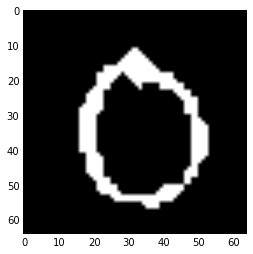

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imb[1:2].reshape(64,64),'gray')

In [133]:
epsilon=np.random.normal(0, 0.01, (nbatch, nz))
sampling_Z = _enc(XXX)[0] + np.exp(_enc(XXX)[1] / 2) * epsilon
sampling_Z=sampling_Z.astype(np.float32)
sampling_Z[0].shape
#_gen(sampling_Z[0])

(1000L,)

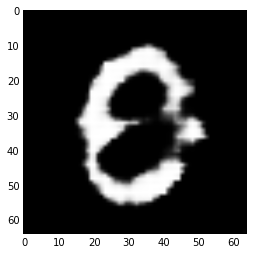

In [26]:
plt.imshow(_gen(_enc(imb[1:2])[0]).reshape(64,64),'gray')

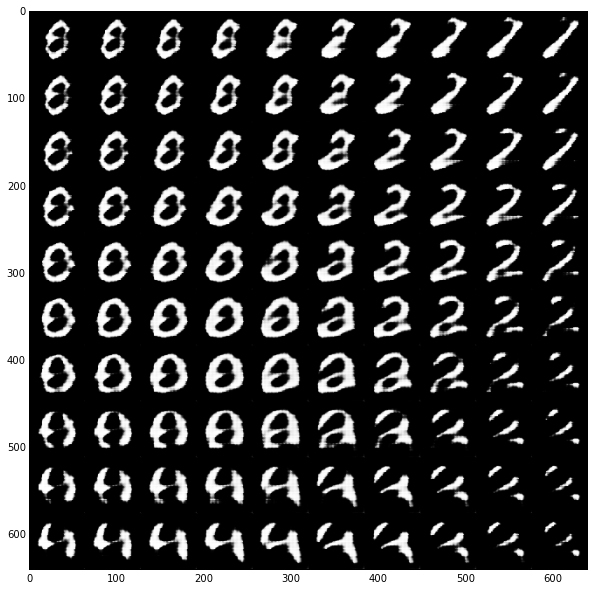

In [27]:
n = 10  # figure with 15x15 digits
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-10, 10, n)
grid_y = np.linspace(-10, 10, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])*0.1
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

In [277]:
import cudarray

ImportError: No module named cudarray